# Predicting Stock Prices with LSTM (5 features)

### Importing Relevent Libraries

In [19]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

### Loading processed_TSLA.csv data


In [20]:
# Load the TSLA data file
data_tsla = pd.read_csv('../data/PAPER_TSLA_data.csv')

file_path = '../data/PAPER_TSLA_data.csv'

data_tsla.head()

,Unnamed: 0,Date,Adj Close,Close,High,Low,Open,Volume
0,0,2014-01-02,10.006667,10.006667,10.165333,9.770000,9.986667,92826000
1,1,2014-01-03,9.970667,9.970667,10.146000,9.906667,10.000000,70425000
2,2,2014-01-06,9.800000,9.800000,10.026667,9.682667,10.000000,80416500
3,3,2014-01-07,9.957333,9.957333,10.026667,9.683333,9.841333,75511500
4,4,2014-01-08,10.085333,10.085333,10.246667,9.917333,9.923333,92448000


### Cofiguration and parameters

In [22]:
config = {
    # Configuration for data preprocessing and splitting
    "data": {
        "window_size": 80,  # Size of the sliding window for time series data
        "train_split_size": 0.95,  # Proportion of data to use for training (95%)
    }, 
    
    # Configuration for plotting and visualization
    "plots": {
        "show_plots": True,  # Whether to display plots or not
        "xticks_interval": 90,  # Interval for x-ticks on plots (e.g., every 90 days)
        "color_actual": "#001f3f",  # Color for the actual data plot (navy blue)
        "color_train": "#3D9970",  # Color for the training data plot (green)
        "color_val": "#0074D9",  # Color for the validation data plot (blue)
        "color_pred_train": "#3D9970",  # Color for the predicted training data plot (green)
        "color_pred_val": "#0074D9",  # Color for the predicted validation data plot (blue)
        "color_pred_test": "#FF4136",  # Color for the predicted test data plot (red)
    },
    
    # Configuration for the LSTM model
    "model": {
        "input_size": 5,  # Number of input features (excluding the Sentiment column)
        "num_lstm_layers": 3,  # Number of LSTM layers in the model
        "lstm_size": 150,  # Number of units in each LSTM layer
        "dropout": 0.6,  # Dropout rate for regularization
    },
    
    # Configuration for training the model
    "training": {
        "device": "cpu",  # Device to train the model on (e.g., 'cpu' or 'cuda')
        "batch_size": 64,  # Number of samples per batch during training
        "num_epoch": 50,  # Number of training epochs
        "learning_rate": 0.001,  # Learning rate for the optimizer
        "scheduler_step_size": 10,  # Step size for the learning rate scheduler
    }
}


### A function to load TSLA data and Ploting the Stock Close values

In [23]:
def load_tsla_data(file_path, plot=False):

    '''
    Loads TSLA stock data from a CSV file and optionally plots the closing prices.

    Parameters:
    - file_path (str): Path to the CSV file.
    - plot (bool): If True, plots the closing prices. Default is False.

    Returns:
    - data_date (list): Dates from the data.
    - data_close_price (numpy array): Closing prices.
    - data_features (numpy array): Features (Open, High, Low, Close, Volume).
    - num_data_points (int): Number of data points.
    - display_date_range (str): Date range of the data.

    Reads and processes the stock data, and plots the closing prices if requested.
    '''

    # Read the TSLA data from the CSV file
    data = pd.read_csv(file_path)

    data_date = data['Date'].tolist()
    data_close_price = data['Close'].tolist()
    data_close_price = np.array(data_close_price)
    
    data_features = data[['Open', 'High', 'Low', 'Close', 'Volume']].values
    data_features = np.array(data_features)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points:", num_data_points, display_date_range)

    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
        xticks = [data_date[i] if ((i % config["plots"]["xticks_interval"] == 0 and (num_data_points - i) > config["plots"]["xticks_interval"]) or i == num_data_points - 1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0, len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily adjusted close price for TSLA, " + display_date_range)
        plt.grid(visible=True, which='major', axis='y', linestyle='--')
        plt.show()

    return data_date, data_close_price, data_features, num_data_points, display_date_range

Number data points: 1510 from 2014-01-02 to 2019-12-31


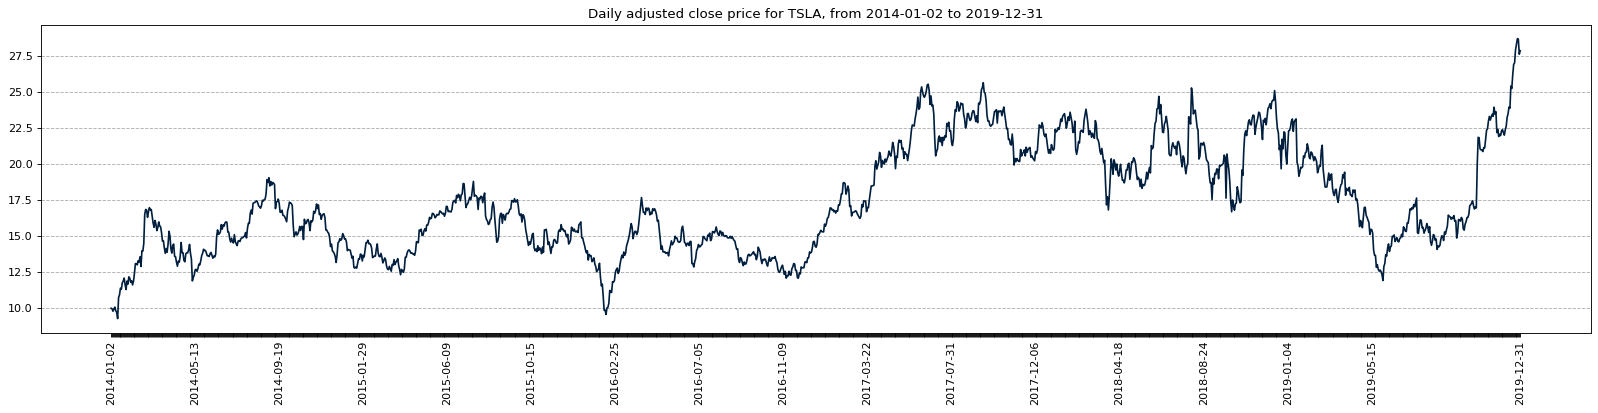

In [24]:
data_date, data_close_price, data_features, num_data_points, display_date_range = load_tsla_data(
    file_path, plot=config["plots"]["show_plots"])

### Data preparation: normalizing raw financial data

In [25]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu) / self.sd
        return normalized_x

    def inverse_transform(self, x, feature_idx=None):
        if feature_idx is not None:
            # Apply inverse transform for a specific feature
            return (x * self.sd[0, feature_idx]) + self.mu[0, feature_idx]
        
        if x.ndim == 1 and self.sd.shape[1] == 1:
            # If x is 1D and there's only one feature in the standard deviation
            return (x * self.sd[0, 0]) + self.mu[0, 0]
        
        if x.ndim == 1:
            # If x is 1D but multiple features exist, raise an informative error
            raise ValueError("Mismatch: input x is 1D, but multiple features exist in the normalizer. Specify feature_idx.")
        
        return (x * self.sd) + self.mu


# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)
normalized_data_features = scaler.fit_transform(data_features)

### Data preparation: generating training and validation datasets

In [26]:
def prepare_data_x(x, window_size):
    '''
    Creates input sequences using a sliding window approach.

    Parameters:
    - x (numpy array): Input features.
    - window_size (int): Size of the sliding window.

    Returns:
    - output (numpy array): Array of input sequences for training.
    - output[-10] (numpy array): Last unseen window for future predictions.
    '''
    # Perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size, x.shape[1]), strides=(x.strides[0], x.strides[0], x.strides[1]))
    return output[:-1], output[-10]

def prepare_data_y(x, window_size):
    '''
    Prepares the target values using the next day's prices.

    Parameters:
    - x (numpy array): Closing prices.
    - window_size (int): Size of the sliding window.

    Returns:
    - output (numpy array): Target values (next day's closing prices).
    '''
    # Use the next day as label
    output = x[window_size:]
    return output

def prepare_data(normalized_data_close_price, normalized_data_features, config, plot=False):
    '''
    Prepares training and validation datasets for model training.

    Parameters:
    - normalized_data_close_price (numpy array): Normalized closing prices.
    - normalized_data_features (numpy array): Normalized input features.
    - config (dict): Configuration dictionary containing window size and train split size.
    - plot (bool): If True, plots the data. Default is False.

    Returns:
    - split_index (int): Index to split the dataset into training and validation sets.
    - data_x_train, data_y_train: Training data (features and target).
    - data_x_val, data_y_val: Validation data (features and target).
    - data_x_unseen: Last unseen window for future predictions.
    '''
    # Prepare input features (X)
    data_x, data_x_unseen = prepare_data_x(normalized_data_features, window_size=config["data"]["window_size"])
    
    # Prepare target values (y)
    data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

    # Split dataset
    split_index = int(data_y.shape[0] * config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]
    
    print(data_x_train.shape)
    print(data_y_train.shape)

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen


# normalized_data_close_price prepared from 'Close' prices

split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen = prepare_data(
    normalized_data_close_price, 
    normalized_data_features, 
    config
)

(1358, 80, 5)
(1358,)


In [27]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        #x = np.expand_dims(x, 2) 
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

Train data shape (1358, 80, 5) (1358,)
Validation data shape (72, 80, 5) (72,)


## Defining the LSTM model

In [28]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

model = LSTMModel(
    input_size=config["model"]["input_size"], 
    hidden_layer_size=config["model"]["lstm_size"], 
    num_layers=config["model"]["num_lstm_layers"], 
    output_size=1, 
    dropout=config["model"]["dropout"])

model = model.to(config["training"]["device"])

## Model training

In [29]:
def run_epoch(dataloader, is_training=False):

    '''
    Runs a single epoch for training or validation.

    Parameters:
    - dataloader: DataLoader object for loading data.
    - is_training (bool): If True, runs in training mode; otherwise, in evaluation mode.

    Returns:
    - epoch_loss: Average loss for the epoch.
    - lr: Current learning rate.
    '''
        
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

# create `DataLoader`
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

# Early stopping parameters
early_stopping_patience = 10  # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0

# begin training
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
          .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))
    
    # Check for early stopping
    if loss_val < best_val_loss:
        best_val_loss = loss_val
        patience_counter = 0  # Reset counter if validation loss improves
    else:
        patience_counter += 1
    
    if patience_counter >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

Epoch[1/50] | loss train:0.063722, test:0.024918 | lr:0.001000
Epoch[2/50] | loss train:0.019861, test:0.008526 | lr:0.001000
Epoch[3/50] | loss train:0.017057, test:0.011345 | lr:0.001000
Epoch[4/50] | loss train:0.016628, test:0.013030 | lr:0.001000
Epoch[5/50] | loss train:0.013857, test:0.007784 | lr:0.001000
Epoch[6/50] | loss train:0.016201, test:0.006988 | lr:0.001000
Epoch[7/50] | loss train:0.012991, test:0.016051 | lr:0.001000
Epoch[8/50] | loss train:0.012739, test:0.005860 | lr:0.001000
Epoch[9/50] | loss train:0.012500, test:0.010038 | lr:0.001000
Epoch[10/50] | loss train:0.012348, test:0.005956 | lr:0.001000
Epoch[11/50] | loss train:0.012012, test:0.004807 | lr:0.000100
Epoch[12/50] | loss train:0.012867, test:0.003957 | lr:0.000100
Epoch[13/50] | loss train:0.009580, test:0.001269 | lr:0.000100
Epoch[14/50] | loss train:0.012362, test:0.003646 | lr:0.000100
Epoch[15/50] | loss train:0.010087, test:0.007702 | lr:0.000100
Epoch[16/50] | loss train:0.010503, test:0.001569

## Model evaluation

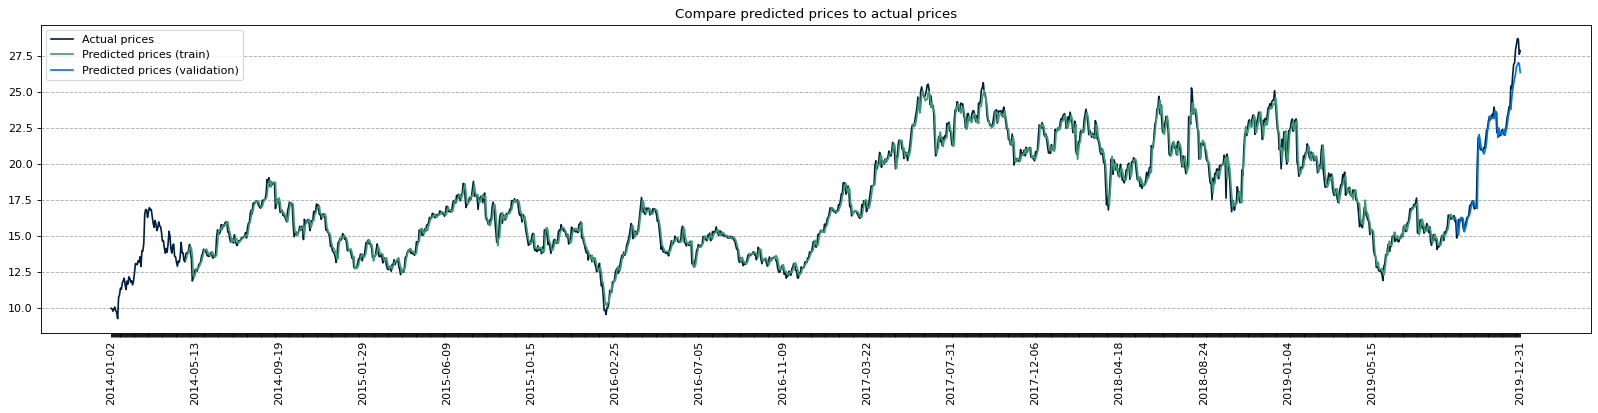

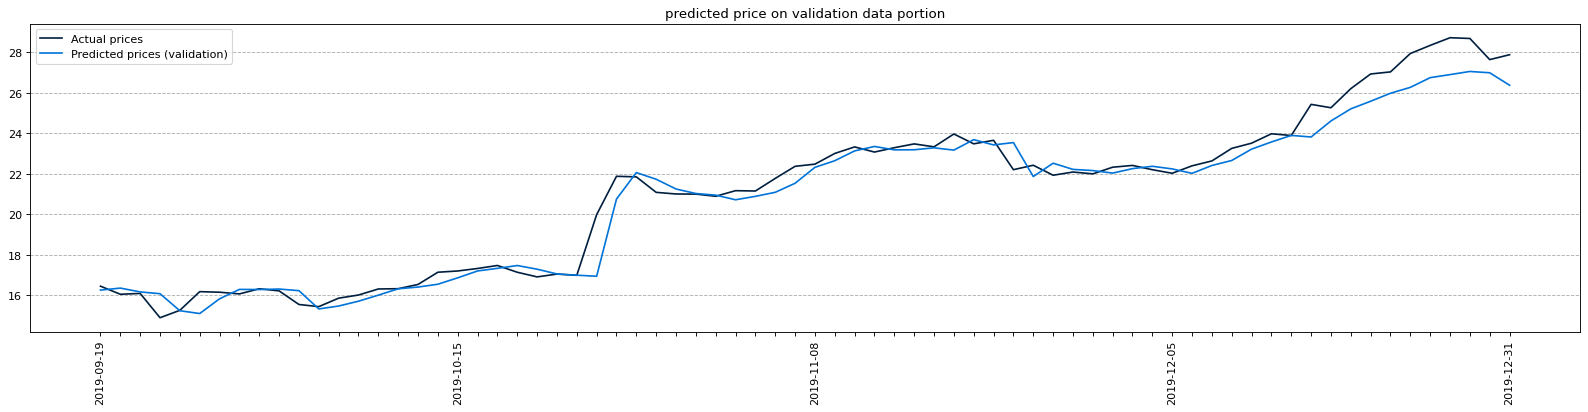

In [30]:
#re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

if config["plots"]["show_plots"]:

    # prepare data for plotting, show predicted prices

    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)

    # Only inverse transform the 'Close' feature (index 3)
    to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train, feature_idx=3)
    to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val, feature_idx=3)



    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
    plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Compare predicted prices to actual prices")
    xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
    x = np.arange(0,len(xticks))
    plt.xticks(x, xticks, rotation='vertical')
    plt.grid(visible=True, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    # prepare data for plotting, zoom in validation
    to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val, feature_idx=3)
    to_plot_predicted_val = scaler.inverse_transform(predicted_val, feature_idx=3)
    to_plot_data_date = data_date[split_index + config["data"]["window_size"]:]


    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("predicted price on validation data portion")
    xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
    xs = np.arange(0,len(xticks))
    plt.xticks(xs, xticks, rotation='vertical')
    plt.grid(visible=True, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

# Prepare the data to be saved
processed_data = pd.DataFrame({
    'Date': data_date,
    'Actual_Close': data_close_price
})

# Add the predicted values to the DataFrame
processed_data['Predicted_Close'] = np.nan
processed_data.loc[config["data"]["window_size"]:split_index+config["data"]["window_size"]-1, 'Predicted_Close'] = scaler.inverse_transform(predicted_train, feature_idx=3).flatten()
processed_data.loc[split_index+config["data"]["window_size"]:num_data_points, 'Predicted_Close'] = scaler.inverse_transform(predicted_val, feature_idx=3).flatten()


# Read the original processed_TSLA.csv
original_data = pd.read_csv('../data/processed_PAPER_TSLA_data.csv')

# Merge the original data with the predicted data based on the Date column
merged_data = pd.merge(original_data, processed_data[['Date', 'Predicted_Close']], on='Date', how='left')

# Save to CSV
merged_data.to_csv('../data/processed_PAPER_TSLA_data.csv', index=False)